In [1]:
import torch
device = torch.device(torch.accelerator.current_accelerator() if torch.accelerator.is_available() else 'cpu')\

device

device(type='cuda')

In [2]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision.transforms import v2
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F



class FoodDataset(torch.utils.data.Dataset):
    def __init__(self, class_list, image_folder):
        self.file_class = class_list
        self.image_folder = image_folder

    def __len__(self):
        return len(self.file_class)
    
    def __getitem__(self, idx):
        image_name = self.file_class.iloc[idx, 0]
        image_path = f"{self.image_folder}/{image_name}"
        image = Image.open(image_path).convert('RGB')

        label = self.file_class.iloc[idx, 1]
        label = torch.tensor(label, dtype=torch.long)

        preprocessing = v2.Compose([
            v2.Resize((224, 224)),
            v2.ToTensor(),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]).to(device)

        image = preprocessing(image)

        return image, label

# Dataset split

In [3]:
train_image_label = pd.read_csv('annot/train_info.csv', names=['image_name', 'label'])

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(train_image_label, train_size = 0.8, test_size=0.2, random_state=42)
reduced_train_df = []
for i in range(251):
    if train_df[train_df['label'] == i].shape[0] > 200:
        # If there are more than 200 samples, sample 200
        reduced_train_df.append(train_df[train_df['label'] == i].sample(200, random_state=42))
    else:
        # If there are less than 200 samples, take all available samples
        reduced_train_df.append(train_df[train_df['label'] == i])

reduced_train_df = pd.concat(reduced_train_df, ignore_index=True)

c:\Users\eliau\OneDrive\Desktop\FoodClassification\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9656862..2.64].


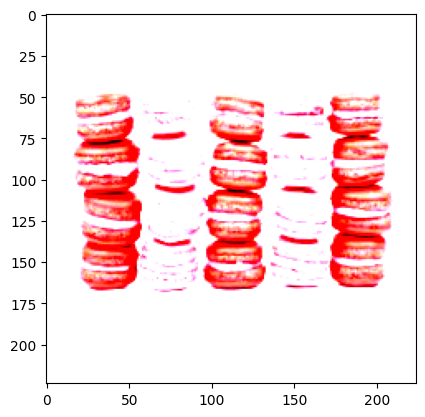

In [4]:
train_dataset = FoodDataset(reduced_train_df, 'train/train_set')
image_train, label_train = train_dataset.__getitem__(0)

plt.imshow(image_train.permute(1, 2, 0).numpy())

val_dataset = FoodDataset(val_df, 'train/train_set')
image_val, label_val = val_dataset.__getitem__(0)

In [5]:
test_df = pd.read_csv('annot/val_info.csv')

test_dataset = FoodDataset(test_df, 'val/val_set')
test_dataset.__getitem__(0)

c:\Users\eliau\OneDrive\Desktop\FoodClassification\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


(tensor([[[-1.6898, -2.0494, -1.9124,  ...,  1.9407,  1.9578,  2.0092],
          [-1.1932, -1.4843, -1.5357,  ...,  1.9235,  1.9407,  1.9920],
          [-0.1143, -0.6109, -0.9877,  ...,  1.9235,  1.9407,  1.9920],
          ...,
          [ 1.3413,  1.4440,  1.5125,  ...,  1.5125,  1.4612,  1.3070],
          [ 1.3755,  1.3584,  1.5125,  ...,  1.4612,  1.4612,  1.4612],
          [ 1.2557,  1.2043,  1.4440,  ...,  1.4269,  1.4440,  1.4954]],
 
         [[-1.5455, -1.9307, -1.6856,  ...,  1.9909,  2.0084,  2.0434],
          [-1.1779, -1.4405, -1.4230,  ...,  2.0084,  2.0259,  2.0609],
          [-0.2325, -0.6877, -1.0203,  ...,  2.0084,  2.0259,  2.0784],
          ...,
          [ 1.2556,  1.3782,  1.5007,  ...,  1.5882,  1.5882,  1.4482],
          [ 1.2906,  1.2731,  1.5007,  ...,  1.5357,  1.5882,  1.6057],
          [ 1.1681,  1.1331,  1.4307,  ...,  1.4832,  1.5357,  1.6057]],
 
         [[-0.7936, -1.2467, -1.0201,  ...,  2.0997,  2.1520,  2.2043],
          [-0.5670, -0.8633,

In [6]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [7]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# classes: array of 0 to 250
# y_train: list of labels for your training set
class_weights = compute_class_weight(class_weight="balanced", classes=np.arange(251), y=train_df.label)
weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=weights)


In [8]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


In [9]:
class FastFoodCNN(nn.Module):
    def __init__(self, num_classes=251):
        super(FastFoodCNN, self).__init__()
        
        def dw_sep_conv_se(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, in_c, kernel_size=3, padding=1, groups=in_c),
                nn.BatchNorm2d(in_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_c, out_c, kernel_size=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                SEBlock(out_c)  # ← Attention over channels
            )

        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            dw_sep_conv_se(64, 128),
            nn.MaxPool2d(2),

            dw_sep_conv_se(128, 256),
            nn.MaxPool2d(2),

            dw_sep_conv_se(256, 512),
            nn.AdaptiveAvgPool2d((1, 1))
        )


        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [10]:
cnn = FastFoodCNN(num_classes=251)
cnn.to(device)

total_params = sum(p.numel() for p in cnn.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")


Total trainable parameters: 354,739


In [ ]:
#train loop
num_epochs = 10
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

shutil.rmtree('runs/food_classification', ignore_errors=True)  # Clear previous runs
writer = SummaryWriter('runs/food_classification')

for epoch in range(num_epochs):
    cnn.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(tqdm(train_dataloader)):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        writer.add_scalar('Loss/train', loss.item(), epoch * len(train_dataloader) + len(images)*i)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader):.4f}")
    
cnn.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(val_dataloader):
        images, labels = images.to(device), labels.to(device)
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * (correct / total)
    print(f'Validation Accuracy: {accuracy:.2f}%')
    

  0%|          | 0/391 [00:00<?, ?it/s]c:\Users\eliau\OneDrive\Desktop\FoodClassification\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
 24%|██▍       | 94/391 [17:57<56:17, 11.37s/it]  

In [ ]:
accuracy = 100 * (correct / total)
print(f'Validation Accuracy: {accuracy:.2f}%')

Validation Accuracy: 0.41%
